In [53]:
import pandas as pd
import warnings
from sqlalchemy import create_engine 
import sys
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pyramid.arima import auto_arima
from numpy import median,mean
import numpy as np
import seaborn as sns

In [60]:
# Reading Raw file
SCDData=pd.read_csv("C:\\Users\\cmishra2\\Documents\\study\\Python schedule\\time series\\raw.csv")
SCDData.head()

,date,sales
0,7/1/2014,762
1,8/1/2014,573
2,9/1/2014,637
3,10/1/2014,770
4,11/1/2014,614


In [61]:
SCDData['date']=SCDData['date'].apply(lambda x: pd.to_datetime(x,errors='ignore'))

In [62]:
SCDData.dtypes

date     datetime64[ns]
sales             int64
dtype: object

            sales
date             
2014-07-01    762
2014-08-01    573
2014-09-01    637
2014-10-01    770
2014-11-01    614


C:\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


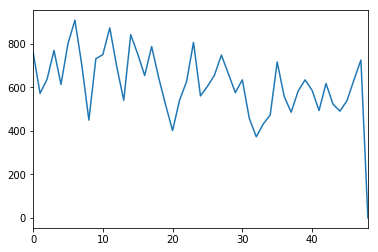

In [63]:
SCDData.index=SCDData.date
SCDData1=SCDData.drop('date', axis=1)
print(SCDData1.head())
sns.tsplot(data=SCDData1.sales)
plt.show()

In [49]:
def remove_outlier(df1):
    q1 = df1.ix[:,1].quantile(0.25)
    q3 = df1.ix[:,1].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df1.ix[:,1] = np.where((df1.ix[:,1] <fence_low) & (df1.ix[:,1] > fence_high), median(df1.ix[:,1]), df1.ix[:,1])
    # Treat zero
    df1.ix[:,1]=df1.ix[:,1].replace(0,df1.ix[:,1].mean())
    return(df1)

def Create_train_test(df1):
    df1.index=df1['date']
    train = df1[0:len(df1)-3]
    test = df1[len(df1)-3:len(df1)]
    print(train.head())
    print(test.head())
    return(train,test)

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))  

def Simple_average(df1,df2):
    #prediction
    future_forecast=[0 for _ in range(len(df2))]
    future_forecast = [df1.ix[:,1].mean() for x in future_forecast]
    Sa_mape=mape(df2.ix[:,1],future_forecast)
    #stderr
    stder=np.std(list(np.array(df1.ix[:,1])-np.array(df1.ix[:,1].mean())))
    return(Sa_mape,future_forecast,stder)

def Simple_Moving(df1,df2):
    #prediction
    future_forecast=[0 for _ in range(len(df2))]
    future_forecast = [df1.ix[:,1].rolling(3).mean().iloc[-1] for x in future_forecast]
    Sm_mape=mape(df2.ix[:,1],future_forecast)
    #stderr
    x1=list(np.array(df1.ix[:,1])-np.array(df1.ix[:,1].rolling(3).mean()))
    l = [x for x in x1 if ~np.isnan(x)]
    stder=np.std(l)
    return(Sm_mape,future_forecast,stder)

def Naive(df1,df2):
    #prediction
    future_forecast=[0 for _ in range(len(df2))]
    future_forecast = [df1.ix[:,1].iloc[-1] for x in future_forecast]
    Na_mape=mape(df2.ix[:,1],future_forecast)
    #stderr
    stder=np.std(np.ediff1d(df1.ix[:,1]))
    return(Na_mape,future_forecast,stder)
    

def Seasonal_Naive(df1,df2):
    #prediction
    daterange =df2['date'].apply(lambda x: x - pd.DateOffset(years=1))
    print(daterange)
    future_forecast=df1.ix[:,1][df1['date'].isin(daterange)]
    SNa_mape=mape(df2.ix[:,1],future_forecast)
    #stderr
    daterange1 =df1['date'].apply(lambda x: x - pd.DateOffset(years=1))
    x=df1.ix[:,1][df1['date'].isin(daterange1)]
    stder=np.std(list(np.array(df1.ix[len(df1)-len(x):len(df1):,1])-np.array(x)))
    return(SNa_mape,future_forecast,stder)
    

###need to correct  stderr  
def Rwdrift(df1,df2):
    #prediction
    y_t = df1.ix[:,1].iloc[-1]
    m = (y_t - df1.ix[:,1].iloc[0]) / len(df1.ix[:,1])
    h = np.linspace(0,len(df2.ix[:,1])-1, len(df2.ix[:,1]))
    future_forecast = y_t + m * h
    Rwd_mape=mape(df2.ix[:,1],future_forecast)
    
    ##stder
    h1 = np.linspace(0,len(df1.ix[:,1])-1, len(df1.ix[:,1]))
    future_forecast1 = y_t + m * h1
    stder=np.std(list(np.array(df1.ix[:,1])-np.array(future_forecast1)))
    print(stder)
    return(Rwd_mape,future_forecast,stder)
    

def Auto_arima(df1,df2):
    stepwise_model = auto_arima(df1.ix[:,1],seasonal=True,trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)
    #prediction
    future_forecast = stepwise_model.predict(n_periods=len(df2))
    Arima_mape=mape(df2.ix[:,1],future_forecast)
    stder=np.std(stepwise_model.resid())
    return(Arima_mape,future_forecast,stder)
    
def SimpleExp_Smoothing(df1,df2):
    stepwise_model = SimpleExpSmoothing(df1.ix[:,1]).fit(smoothing_level= 0.6,optimized=False)
    #prediction
    future_forecast = stepwise_model.forecast(len(df2))
    Ses_mape=mape(future_forecast,df2.ix[:,1])
    stder=np.std(stepwise_model.resid)
    return(Ses_mape,future_forecast,stder)

def Holtwinter_Linear(df1,df2):
    stepwise_model = Holt(df1.ix[:,1]).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
    #prediction
    future_forecast = stepwise_model.forecast(len(df2))
    Holtli_mape=mape(df2.ix[:,1],future_forecast)
    stder=np.std(stepwise_model.resid)
    return(Holtli_mape,future_forecast,stder)

def Holtwinter_Seasonal(df1,df2):
    stepwise_model = ExponentialSmoothing(df1.ix[:,1],seasonal_periods=3 ,trend='add', seasonal='add').fit()
    #prediction
    future_forecast = stepwise_model.forecast(len(df2))
    holtwi_mape=mape(df2.ix[:,1],future_forecast)
    stder=np.std(stepwise_model.resid)
    print(stder)
    return(holtwi_mape,future_forecast,stder)


In [50]:
df11=remove_outlier(SCDData)
train,test=Create_train_test(df11)
Sa_mape,Sa_future,Sa_Resstd=Simple_average(train,test)
Sm_mape,Sm_future,Sm_Resstd=Simple_Moving(train,test)
Na_mape,Na_future,Na_Resstd=Naive(train,test)
SNa_mape,SNa_future,SNa_Resstd=Seasonal_Naive(train,test)
Rwd_mape,Rwd_future,Rwd_Resstd=Rwdrift(train,test)
Arima_mape,Arima_future,Arima_Resstd=Auto_arima(train,test)
Ses_mape,Ses_future,Ses_Resstd=SimpleExp_Smoothing(train,test)
Holtli_mape,Holtli_future,Holtli_Resstd=Holtwinter_Linear(train,test)
Holtwi_mape,Holtwi_future,Holtwi_Resstd=Holtwinter_Seasonal(train,test)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


                 date  sales
date                        
2014-07-01 2014-07-01  762.0
2014-08-01 2014-08-01  573.0
2014-09-01 2014-09-01  637.0
2014-10-01 2014-10-01  770.0
2014-11-01 2014-11-01  614.0
                 date       sales
date                             
2018-05-01 2018-05-01  634.000000
2018-06-01 2018-06-01  726.000000
2018-07-01 2018-07-01  615.612245
date
2018-05-01   2017-05-01
2018-06-01   2017-06-01
2018-07-01   2017-07-01
Name: date, dtype: datetime64[ns]
110.16527421005648
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=562.254, BIC=573.094, Fit time=0.541 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=577.176, BIC=580.789, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=576.647, BIC=582.067, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=561.657, BIC=567.077, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=561.486, BIC=568.

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


121.1768782204246
